In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import norm

from tqdm.auto import tqdm
from scipy.stats import iqr
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(
    font_scale =1,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [3]:
# зададим параметры отображения
pd.set_option('display.max_colwidth', 0)
pd.options.display.max_columns = None

## Задание 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания проанализирую итоги эксперимента и сделаю вывод, стоит ли запускать новую механику оплаты на всех пользователей.

**Входные данные**

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [4]:
groups = pd.read_csv("Проект_2_groups.csv",sep= ";")
group_add = pd.read_csv("Проект_2_group_add.csv",sep= ",")
active_studs = pd.read_csv("Проект_2_active_studs.csv",sep= ";")
checks = pd.read_csv("Проект_2_checks.csv",sep= ";")

In [5]:
def info(df):
    print("*" * 10)
    print("head:")
    print(df.head())
    print("*" * 10)
    print("shape:")
    print(df.shape)
    print("*" * 10)
    print("dtpyes:")
    print(df.dtypes)
    print("*" * 10)
    print("count_null:")
    print(df.isna().sum())
    print("*" * 10)
    print("count_duplicates:")
    print(df.duplicated().sum())
    print("*" * 10)

In [6]:
info(groups)

**********
head:
     id grp
0  1489  B 
1  1627  A 
2  1768  B 
3  1783  B 
4  1794  A 
**********
shape:
(74484, 2)
**********
dtpyes:
id     int64 
grp    object
dtype: object
**********
count_null:
id     0
grp    0
dtype: int64
**********
count_duplicates:
0
**********


In [7]:
info(group_add)

**********
head:
        id grp
0  5694584  B 
1  5694830  B 
2  5695057  B 
3  5698872  B 
4  5699067  B 
**********
shape:
(92, 2)
**********
dtpyes:
id     int64 
grp    object
dtype: object
**********
count_null:
id     0
grp    0
dtype: int64
**********
count_duplicates:
0
**********


In [8]:
info(active_studs)

**********
head:
   student_id
0  581585    
1  5723133   
2  3276743   
3  4238589   
4  4475369   
**********
shape:
(8341, 1)
**********
dtpyes:
student_id    int64
dtype: object
**********
count_null:
student_id    0
dtype: int64
**********
count_duplicates:
0
**********


In [9]:
info(checks)

**********
head:
   student_id    rev
0  1627        990.0
1  3185        690.0
2  25973       690.0
3  26280       690.0
4  100300      990.0
**********
shape:
(541, 2)
**********
dtpyes:
student_id    int64  
rev           float64
dtype: object
**********
count_null:
student_id    0
rev           0
dtype: int64
**********
count_duplicates:
0
**********


**Разведочный анализ данных (exploratory data analysis, EDA)**

In [10]:
groups.rename(columns={ groups.columns[0]: "student_id"}, inplace = True) 
group_add.rename(columns={ group_add.columns[0]: "student_id"}, inplace = True)
full_groups = groups.append(group_add) # сформируем общий df для дальнейшего анализа

In [11]:
full_groups.duplicated().sum() 

0

In [12]:
full_groups.value_counts("grp")

grp
B    59883
A    14693
dtype: int64

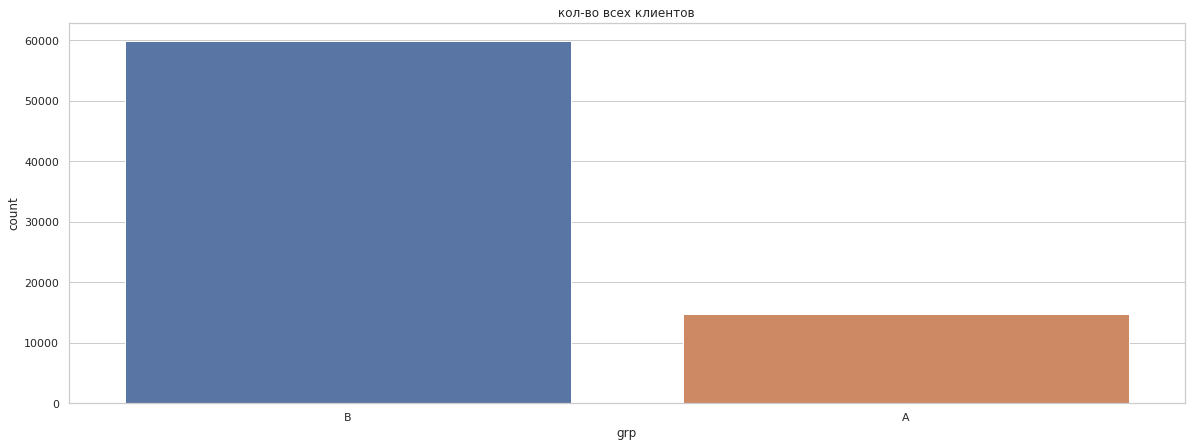

In [13]:
# Визуализируем распределения пользователей в двух группах
sns.countplot(data=full_groups,x="grp").set(title=' кол-во всех клиентов ');

In [14]:
round(active_studs.shape[0] / full_groups.shape[0] * 100,2) #  % пользователей, посетивших сайт во время эксперемента.

11.18

In [15]:
checks.shape[0] - checks.merge(active_studs, on = "student_id").shape[0] 

149

149 пользователей, оплатившие услугу, отсутсвуют в таблице **active_studs**. Вероятно всего у сервиса есть некая система автоплатежа либо это и есть новая механика оплаты которую мы проверяем (а может быть еще что у пользователей вообще есть другая возможность пользоваться сервисом).В дальнейшем будем всех оплативших пользователей учитывать в эксперименте.

Посмотрим на распределение чеков между всеми платящами пользователями в дни эксперемента

In [16]:
checks.rename(columns={ checks.columns[1]: "revenue"}, inplace = True) 
checks.revenue.value_counts().reset_index().rename(columns={ "index": "revenue",checks.columns[1]: "count"}) 

,revenue,count
0,1900.0000,97
1,290.0000,94
2,690.0000,78
3,199.0000,46
4,990.0000,41
5,1900.0001,36
6,840.0000,27
7,1140.0000,25
8,580.0000,15
9,590.0000,11


In [17]:
checks

,student_id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [18]:
checks['revenue'].describe()

count    541.000000 
mean     1059.752317
std      762.712359 
min      199.000000 
25%      290.000000 
50%      840.000000 
75%      1900.000000
max      4650.000000
Name: revenue, dtype: float64

In [19]:
checks["payed"] = 1

In [20]:
active_studs2 = checks.merge(active_studs, on = "student_id",how = "outer") 

In [21]:
active_studs2.duplicated().sum()

0

In [22]:
full_groups = active_studs2.merge(full_groups, on = "student_id",how = "left")
full_groups

,student_id,revenue,payed,grp
0,1627,990.0,1.0,A
1,3185,690.0,1.0,B
2,25973,690.0,1.0,B
3,26280,690.0,1.0,B
4,100300,990.0,1.0,B
...,...,...,...,...
8485,264371,NaN,NaN,B
8486,1794344,NaN,NaN,B
8487,296883,NaN,NaN,B
8488,3598448,NaN,NaN,B


In [23]:
full_groups.query("grp == 'A'").revenue.sum()

92096.0

In [24]:
full_groups.query("grp == 'A' & payed > 0").revenue.quantile(q=[0.25,0.5,0.75])

0.25    290.0
0.50    690.0
0.75    990.0
Name: revenue, dtype: float64

In [25]:
full_groups.query("grp == 'B'").revenue.sum()

481230.0036

In [26]:
full_groups.query("grp == 'B' & payed > 0").revenue.quantile(q=[0.25,0.5,0.75])

0.25    420.75 
0.50    935.00 
0.75    1900.00
Name: revenue, dtype: float64

In [27]:
full_groups.query("grp == 'A' & payed > 0").revenue.nunique()

23

In [28]:
full_groups.query("grp == 'B' & payed > 0").revenue.nunique()

35

В двух группах замечено большое количество одинаковых оплат, но при этом в эксперементальной группе у пользователей         отмечено гораздо большее количество вариантов таких оплат. Возможно связано это с новой механикой оплаты где у пользователей мог появиться некий нижний порог оплаты услуги и/или более оптимальные(гибкие) варианты покупки, при которых можно было бы приобрести только часть услуги.

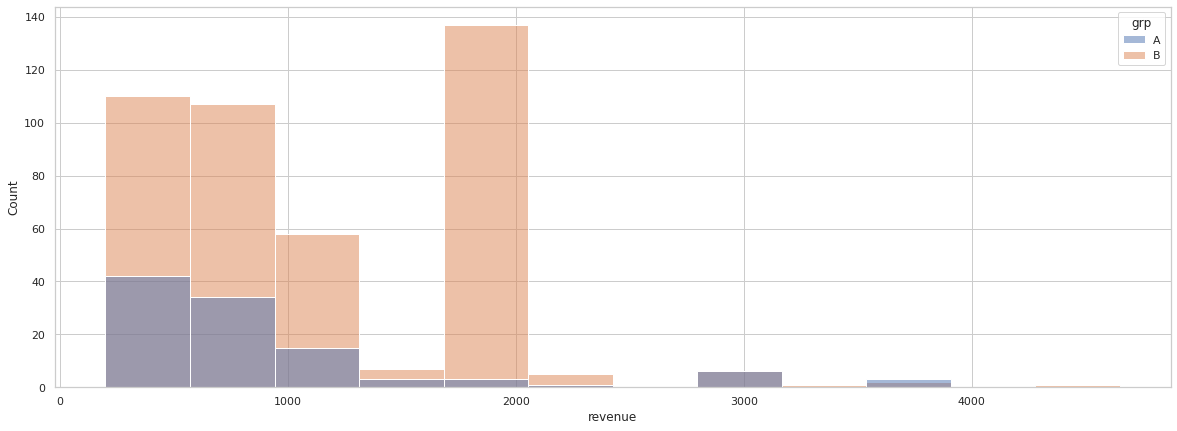

In [29]:
sns.histplot(data=full_groups.query("payed == 1")[['revenue', 'grp']], x ='revenue', hue ='grp');

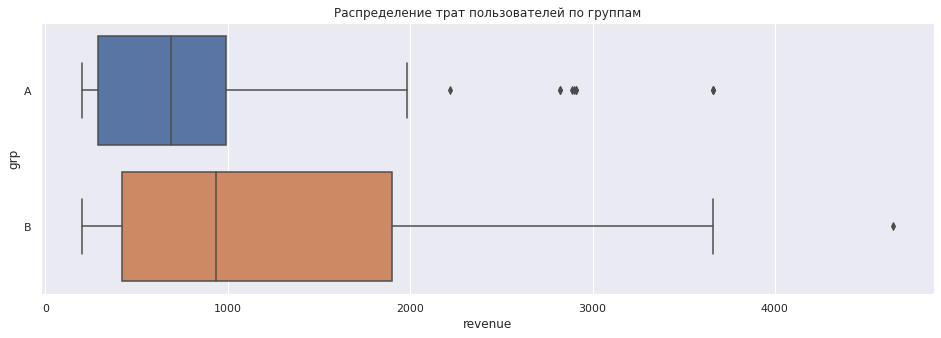

In [30]:
sns.set(rc={'figure.figsize':(16,5)})
sns.boxplot(data=full_groups, x=full_groups.query("payed == 1").revenue, y=full_groups.grp)\
            .set(title='Распределение трат пользователей по группам');

In [31]:
# можно применить тест Шапиро-Уилка, но он покажет тот же результат
stats.normaltest(full_groups.query("grp == 'B' & payed == 1")["revenue"])  

NormaltestResult(statistic=33.19587456725772, pvalue=6.18881394639434e-08)

In [32]:
stats.normaltest(full_groups.query("grp == 'A' & payed == 1")["revenue"])

NormaltestResult(statistic=52.21845240353401, pvalue=4.580439316510776e-12)

Распределение каждой из групп являетеся ненормальным,  также оба имеют большие выбросы

По имеющимся данным просчитаем следующие метрики:

- **CR** Конверсия пользователя в покупку % 

- **ARPU** Средний платеж на одного пользователя

- **ARPPU** Средняя платеж от одного платящего пользователя 

- **Mean_revenue** Средний доход от платящих пользователей 

In [40]:
full_groups

,student_id,revenue,payed,grp
0,1627,990.0,1.0,A
1,3185,690.0,1.0,B
2,25973,690.0,1.0,B
3,26280,690.0,1.0,B
4,100300,990.0,1.0,B
...,...,...,...,...
8485,264371,NaN,NaN,B
8486,1794344,NaN,NaN,B
8487,296883,NaN,NaN,B
8488,3598448,NaN,NaN,B


In [35]:
Metrics = pd.DataFrame()
Metrics["payed_users"] = full_groups.query("payed == 1").groupby("grp")\
                    .student_id.count()
Metrics["active_users"] = full_groups.groupby("grp")\
                    .student_id.count()
Metrics["CR"] = round(Metrics["payed_users"] / Metrics["active_users"] * 100,2)
Metrics["ARPPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.mean(),2)
Metrics["ARPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.sum() / Metrics["active_users"],2)
Metrics["Mean_revenue"] = round(full_groups.query("payed == 1").groupby("grp").revenue.mean(),2)
Metrics

,payed_users,active_users,CR,ARPPU,ARPU,Mean_revenue
A,107,1567,6.83,860.71,58.77,860.71
B,434,6923,6.27,1108.82,69.51,1108.82


Чтобы посчитать статистическую значимость между двумя группами можно было воспользоваться непараметрическим критерием независимых выборок U - test, но поскольку у нас очень много одинаковых оплат в двух группах,то при ранжировании и  при парном сравнение сумм индификаторов двух групп получим некорректный результат. Поэтому для корретного проведения эксперемента  воспользуюсь бутсрапом, но из за асимитричного распределения выборок подберем другую метрику - Медианный доход от активного пользователя (**MRPAU**) 

**Проверка гипотезы**

**H0** - Новая механика оплаты услуг не отличается от старой механики.     
**H1** - Новая механика оплаты услуг отличается от старой механики.

Хотя требование к распределению не соблюдено, можно провести t test, но для этого важно проверить равенство дисперсий в двух выборках (гомогенность), чтобы провести t test

In [36]:
stats.levene(full_groups.query("grp == 'A' & payed == 1").revenue, full_groups.query("grp == 'B' & payed == 1").revenue)

LeveneResult(statistic=4.478900854248498, pvalue=0.03477352573759214)

pvalue < 0.05. Дисперсии обоих групп не однородны. Хотя у нас выборки имеют не так много наблюдений и это могло сказаться  на тест, проверять гипотезу будем только бутсрапом.

In [49]:
#MRPAU
def get_bootstrap(
    df_Treatment, # числовые значения первой выборки
    df_control, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок (увеличим до 10 к)
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = df_Treatment.sample(
            len(df_Treatment), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = df_control.sample(
            len(df_control), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

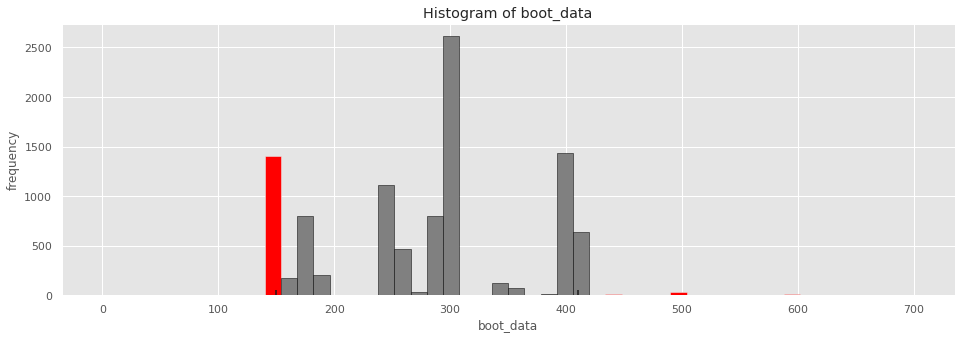

In [50]:
booted_data = get_bootstrap(full_groups.query("grp == 'B' & payed == 1").revenue, full_groups.query("grp == 'A' & payed == 1").revenue) # в результате хранится разница двух распределений, ДИ и pvalue

In [51]:
booted_data["p_value"] # расчет по медиане

0.0014353345125202655

In [52]:
booted_data["quants"] # Доверительный интервал не пересекает 0 

,0
0.025,150.0
0.975,410.0


               Результат: p_value < 0.05 , это дает нам основание отклонить нулевую гипотезу. 
               Различия стат. значимы. 
               Новую  механику оплаты можно раскатить при условии, что мы получили корректные данные на вход.

## Задание 2. SQL

### 2.1 Очень усердные ученики.

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

**Задача. Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.**

*Решение.*

In [40]:
import pandahouse as ph

In [41]:
# для подключения к таблице default в clickhouse:
connection_default = {'host': 'http://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [42]:
 # Оптимальный запрос о количестве учеников
 # Поскольку данные в таблице предствлены только за один месяц, считаю что если буду оринтироваться по последнему месяцу, то это будет также допустимо.
q = '''
       Select uniqExact(st_id) as diligent_students 
    From
        (SELECT st_id,
                sum(correct) as correct_answers
        FROM peas
        Where Month(timest) = (select max(month(timest)) from peas) 
        Group by st_id
        having  correct_answers >= 20) t1
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
diligent_students = ph.read_clickhouse(query=q, connection=connection_default)

In [43]:
print(f"Всего {diligent_students.diligent_students.iat[0]} усердных учеников за текущий месяц")

Всего 136 усердных учеников за текущий месяц


**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день.  
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ.     
          Команда провела эксперимент, где был протестирован новый экран оплаты.

**Задача. Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

ARPU 
ARPAU 
CR в покупку 
СR активного пользователя в покупку 
CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

*Решение.*

***Предворительно определим метрики***

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [44]:
q = '''
with 
    ARPU as (select a.test_grp, sum(money) / uniqExact(a.st_id) as ARPU from studs a
                  left join default.final_project_check b
                  using (st_id)
                  GROUP BY a.test_grp),
    ARPAU as (select a.test_grp, sum(money) / uniqExact(a.st_id) as ARPAU from studs a
              left join default.final_project_check b
              using (st_id)
              Where st_id in ( Select st_id from peas
                               Where correct = 1
                               Group by st_id
                               having count(correct) > 10)
             Group by test_grp),
    CR AS (select test_grp, count(distinct(b.st_id)) filter (where money != 0)  / count(distinct(st_id)) * 100 as CR from studs a
           left join final_project_check b
           using (st_id)
           GROUP BY test_grp),
    CR_active AS (select test_grp, count(distinct(b.st_id)) filter (where money != 0)  / count(distinct(st_id)) * 100 as CR_active from studs a
                  left join final_project_check b
                  using (st_id)
                  Where st_id in ( Select st_id from peas
                                   Where correct = 1
                                   Group by st_id
                                   having sum(correct) > 10)
                  Group by test_grp),
    CR_active_math as (select test_grp, count(distinct(b.st_id)) filter (where subject = 'Math')  / count(distinct(st_id)) * 100 as CR_active_math from studs a
                       left join final_project_check b
                       using (st_id)
                       Where st_id in ( Select st_id from peas
                                        Where subject = 'Math' and correct = 1
                                        Group by st_id
                                        having count(correct) >= 2)
                        Group by test_grp)

Select ARPU.test_grp as test_grp, round(ARPU.ARPU,2) as ARPU, round(ARPAU.ARPAU,2) as ARPAU, round(CR.CR,2) as CR, round(CR_active.CR_active,2) as CR_active, round(CR_active_math.CR_active_math, 2) as CR_active_math From  ARPU
join ARPAU on ARPU.test_grp = ARPAU.test_grp
join CR on ARPU.test_grp = CR.test_grp
join CR_active on ARPU.test_grp = CR_active.test_grp
join CR_active_math on ARPU.test_grp = CR_active_math.test_grp
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
metrics = ph.read_clickhouse(query=q, connection=connection_default)
metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_active_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


**Вывод**

На основе данных можно сделать вывод, что новый экран оплаты повысит все ключевые метрики платформы практически в два раза.

# Задание 3. Python

**3.1.1 Условие**

Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [45]:
def make_metrics():
    groups = pd.read_csv("Проект_2_groups.csv",sep= ";")
    group_add = pd.read_csv("Проект_2_group_add.csv",sep= ",")
    active_studs = pd.read_csv("Проект_2_active_studs.csv",sep= ";")
    checks = pd.read_csv("Проект_2_checks.csv",sep= ";")
    group_add.drop_duplicates()
    groups.rename(columns={ groups.columns[0]: "student_id"}, inplace = True) 
    group_add.rename(columns={ group_add.columns[0]: "student_id"}, inplace = True)
    checks.rename(columns={ checks.columns[1]: "revenue"}, inplace = True) 
    full_groups = groups.append(group_add)
    checks["payed"] = 1
    active_studs2 = checks.merge(active_studs, on = "student_id",how = "outer") 
    full_groups = active_studs2.merge(full_groups, on = "student_id",how = "left")
    Metrics = pd.DataFrame()
    Metrics["payed_users"] = full_groups.query("payed == 1").groupby("grp")\
                    .student_id.count()
    Metrics["active_users"] = full_groups.groupby("grp")\
                    .student_id.count()
    Metrics["CR"] = round(Metrics["payed_users"] / Metrics["active_users"] * 100,2)
    Metrics["ARPPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.mean(),2)
    Metrics["ARPU"] = round(full_groups.query("payed == 1").groupby("grp")\
                    .revenue.sum() / Metrics["active_users"],2)
    Metrics["Mean_revenue"] = round(full_groups.query("payed == 1").groupby("grp").revenue.mean(),2)
    return Metrics

In [46]:
Metrics = make_metrics()
Metrics

,payed_users,active_users,CR,ARPPU,ARPU,Mean_revenue
A,107,1567,6.83,860.71,58.77,860.71
B,434,6923,6.27,1108.82,69.51,1108.82


**3.1.2 Условие**

Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [47]:
def visualization_metrics(Metrics):
    Metrics = Metrics.reset_index().rename(columns={"index": "Group"})
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.tight_layout(h_pad=4)
    sns.barplot(y='payed_users', x="Group", data=Metrics, ax=axs[0, 0]).set_title('payed_users')
    sns.barplot(y='active_users', x="Group", data=Metrics, ax=axs[0, 1]).set_title('active_users')
    sns.barplot(y='CR', x="Group", data=Metrics, ax=axs[0, 2]).set_title('Conversion')
    sns.barplot(y='ARPPU', x="Group", data=Metrics, ax=axs[1,0]).set_title('ARPPU')
    sns.barplot(y='ARPU', x="Group", data=Metrics, ax=axs[1,1]).set_title('ARPU')
    sns.barplot(y='Mean_revenue', x="Group", data=Metrics, ax=axs[1,2]).set_title('Mean_revenue')
    plt.show() 

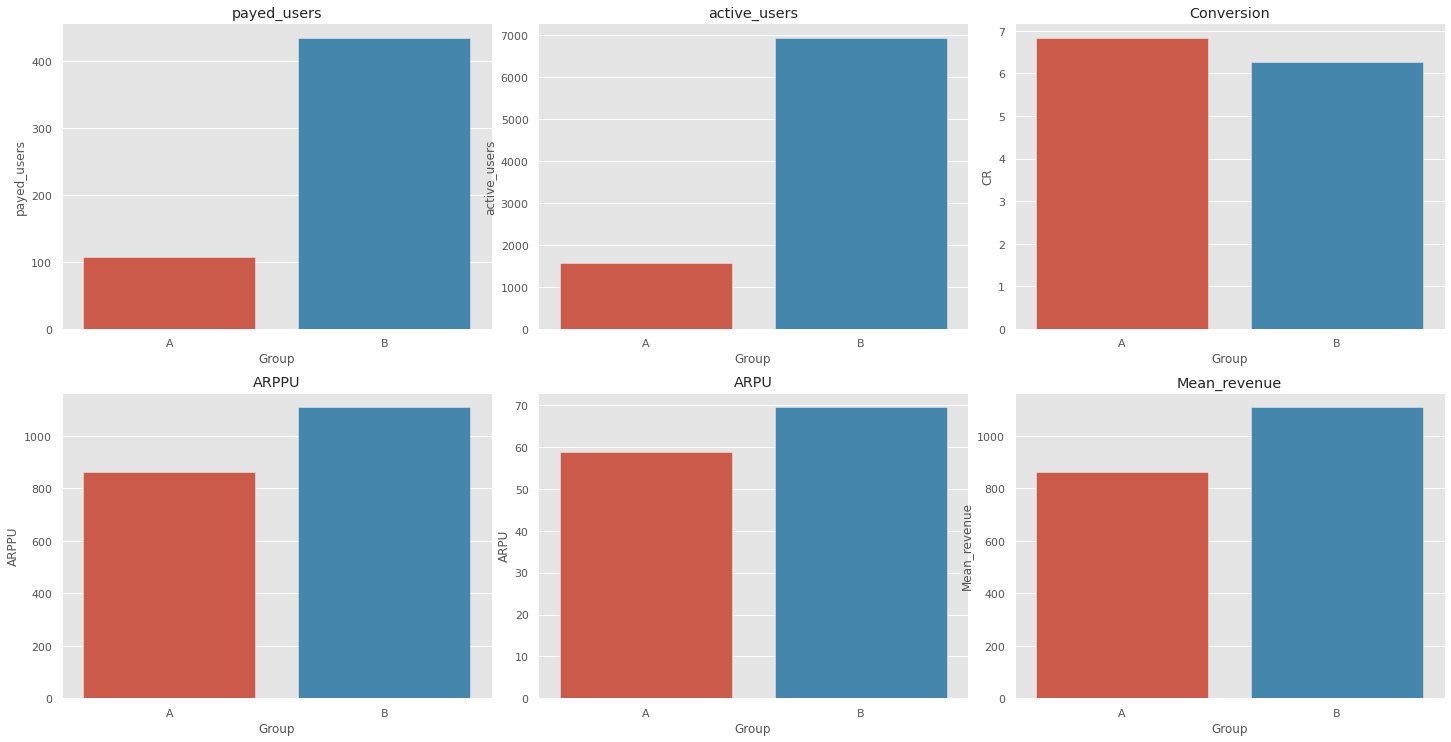

In [48]:
visualization_metrics(Metrics)